## <center> Implied Volatility Dynamics </center> 

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd 

from numba import jit, prange
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt 

## <center> Set Seaborn Theme </center>

In [2]:
sns.set_theme(
    style = "darkgrid",
    palette = "bright",
)

plt.rc('figure', figsize = (10, 5))

## <center> Fetch DataFrame from Yahoo Finance </center> 

In [3]:
df = yf.download("VIXY VIXM UVXY ^VIX")
list(df.columns)

[*********************100%%**********************]  4 of 4 completed


[('Adj Close', 'UVXY'),
 ('Adj Close', 'VIXM'),
 ('Adj Close', 'VIXY'),
 ('Adj Close', '^VIX'),
 ('Close', 'UVXY'),
 ('Close', 'VIXM'),
 ('Close', 'VIXY'),
 ('Close', '^VIX'),
 ('High', 'UVXY'),
 ('High', 'VIXM'),
 ('High', 'VIXY'),
 ('High', '^VIX'),
 ('Low', 'UVXY'),
 ('Low', 'VIXM'),
 ('Low', 'VIXY'),
 ('Low', '^VIX'),
 ('Open', 'UVXY'),
 ('Open', 'VIXM'),
 ('Open', 'VIXY'),
 ('Open', '^VIX'),
 ('Volume', 'UVXY'),
 ('Volume', 'VIXM'),
 ('Volume', 'VIXY'),
 ('Volume', '^VIX')]

In [4]:
df = df[df["Adj Close", "UVXY"].notna()]

In [5]:
df.head()

Adj Close                                          Close  \
                    UVXY        VIXM      VIXY       ^VIX          UVXY   
Date                                                                      
2011-10-04  2.058000e+10  359.160004  226900.0  40.820000  2.058000e+10   
2011-10-05  1.813800e+10  352.399994  215320.0  37.810001  1.813800e+10   
2011-10-06  1.740000e+10  350.399994  211720.0  36.270000  1.740000e+10   
2011-10-07  1.765200e+10  355.559998  215560.0  36.200001  1.765200e+10   
2011-10-10  1.559400e+10  339.559998  199920.0  33.020000  1.559400e+10   

                                                     High              ...  \
                  VIXM      VIXY       ^VIX          UVXY        VIXM  ...   
Date                                                                   ...   
2011-10-04  359.160004  226900.0  40.820000  2.448000e+10  380.000000  ...   
2011-10-05  352.399994  215320.0  37.810001  1.989000e+10  360.920013  ...   
2011-10-06  350.399994  211720.0  36.270000  1.878000e+10  355.200012  ...   
2011-10-07  355.559998  215560.0  36.200001  1.857600e+10  358.480011  ...   
2011-10-10  339.559998  199920.0  33.020000  1.656000e+10  346.600006  ...   

                 Low                     Open                        \
                VIXY       ^VIX          UVXY        VIXM      VIXY   
Date                                                                  
2011-10-04  225400.0  40.020000  2.427000e+10  372.679993  249840.0   
2011-10-05  214440.0  37.509998  1.974600e+10  358.920013  223480.0   
2011-10-06  211400.0  36.150002  1.811400e+10  352.239990  216480.0   
2011-10-07  207440.0  35.189999  1.705800e+10  346.040009  207600.0   
2011-10-10  199840.0  32.959999  1.654800e+10  345.959991  206600.0   

                      Volume                      
                 ^VIX   UVXY    VIXM   VIXY ^VIX  
Date                                              
2011-10-04  46.180000    0.0  6975.0  337.0    0  
2011-10-05  40.730000    0.0  6250.0  181.0    0  
2011-10-06  38.240002    0.0  5250.0   97.0    0  
2011-10-07  35.669998    0.0  4525.0  225.0    0  
2011-10-10  35.450001    0.0  2400.0   95.0    0  

[5 rows x 24 columns]

In [6]:
df.tail()

Adj Close                               Close             \
                UVXY       VIXM       VIXY   ^VIX   UVXY       VIXM   
Date                                                                  
2023-09-13     13.49  18.469999  20.549999  13.48  13.49  18.469999   
2023-09-14     12.87  18.150000  19.920000  12.82  12.87  18.150000   
2023-09-15     13.62  18.510000  20.680000  13.79  13.62  18.510000   
2023-09-18     13.48  18.450001  20.540001  14.00  13.48  18.450001   
2023-09-19     13.36  18.290001  20.400000  14.11  13.36  18.290001   

                               High             ...        Low          Open  \
                 VIXY   ^VIX   UVXY       VIXM  ...       VIXY   ^VIX   UVXY   
Date                                            ...                            
2023-09-13  20.549999  13.48  13.78  18.530001  ...  20.389999  13.41  13.72   
2023-09-14  19.920000  12.82  13.28  18.389999  ...  19.870001  12.79  13.22   
2023-09-15  20.680000  13.79  13.70  18.510000  ...  19.830000  12.68  13.01   
2023-09-18  20.540001  14.00  14.03  18.650000  ...  20.200001  13.86  13.88   
2023-09-19  20.400000  14.11  13.97  18.690001  ...  20.280001  13.86  13.48   

                                             Volume                           
                 VIXM       VIXY   ^VIX        UVXY     VIXM       VIXY ^VIX  
Date                                                                          
2023-09-13  18.459999  20.730000  14.42  19188900.0  22400.0  2625200.0    0  
2023-09-14  18.389999  20.219999  13.39  16294400.0  86600.0  2549500.0    0  
2023-09-15  18.230000  20.030001  12.70  24605600.0  79000.0  4381400.0    0  
2023-09-18  18.650000  20.920000  14.40  17009600.0  68700.0  3639300.0    0  
2023-09-19  18.400000  20.540001  14.11  21977900.0  74000.0  4122300.0    0  

[5 rows x 24 columns]

## <center> Coefficient of Determination </center>

## <center> $ R^2 = 1 - \frac{\sum_{i=1}^{N} (y_{i} - f_{i})^2}{\sum_{i=1}^{N} (y_{i} - \hat{y})^2} $ </center>

In [7]:
@jit(nopython = True, parallel = True)
def compute_r2(y, y_hat):
    """
    
    """
    
    RSS = np.sum((y - y_hat)**2)
    TSS = np.sum((y_hat - np.mean(y_hat))**2)
    
    R2 = 1 - (RSS / TSS)
    
    return R2

In [8]:
@jit(nopython = True, parallel = True)
def compute_log_returns(arr):
    """
    
    """
    
    N = len(arr)
    series = np.zeros(N - 1)
    
    for i in prange(N - 1):
        series[i] = np.log(arr[i + 1] / arr[i]) * 100
        
    return series

In [9]:
@jit(nopython = True, parallel = True)
def compute_intraday_log_returns(open_price, close_price):
    """
    
    """
    
    N = len(close_price)
    series = np.zeros(N)
    
    for i in prange(N):
        series[i] = np.log(close_price[i] / open_price[i]) * 100
        
    return series

In [10]:
@jit(nopython = True, parallel = True)
def compute_overnight_returns(open_price, close_price):
    """
    
    """
    
    N = len(close_price)
    series = np.zeros(N)
    
    for i in prange(N - 1):
        series[i] = np.log(open_price[i+1] / close_price[i]) * 100
        
    return series

In [11]:
vixm_open_returns = compute_log_returns(df["Open", "VIXM"].to_numpy())
vixy_open_returns = compute_log_returns(df["Open", "VIXY"].to_numpy())
uvxy_open_returns = compute_log_returns(df["Open", "UVXY"].to_numpy())
ivol_open_returns = compute_log_returns(df["Open", "^VIX"].to_numpy())

vixm_close_returns = compute_log_returns(df["Adj Close", "VIXM"].to_numpy())
vixy_close_returns = compute_log_returns(df["Adj Close", "VIXY"].to_numpy())
uvxy_close_returns = compute_log_returns(df["Adj Close", "UVXY"].to_numpy())
ivol_close_returns = compute_log_returns(df["Adj Close", "^VIX"].to_numpy())

vixm_intraday = compute_intraday_log_returns(df["Open", "VIXM"].to_numpy(), df["Close", "VIXM"].to_numpy())
vixy_intraday = compute_intraday_log_returns(df["Open", "VIXY"].to_numpy(), df["Close", "VIXY"].to_numpy())
uvxy_intraday = compute_intraday_log_returns(df["Open", "UVXY"].to_numpy(), df["Close", "UVXY"].to_numpy())
ivol_intraday = compute_intraday_log_returns(df["Open", "^VIX"].to_numpy(), df["Close", "^VIX"].to_numpy())

vixm_overnight = compute_overnight_returns(df["Open", "VIXM"].to_numpy(), df["Close", "VIXM"].to_numpy())
vixy_overnight = compute_overnight_returns(df["Open", "VIXY"].to_numpy(), df["Close", "VIXY"].to_numpy())
uvxy_overnight = compute_overnight_returns(df["Open", "UVXY"].to_numpy(), df["Close", "UVXY"].to_numpy())
ivol_overnight = compute_overnight_returns(df["Open", "^VIX"].to_numpy(), df["Close", "^VIX"].to_numpy())

## <center> UVXY Density </center> 

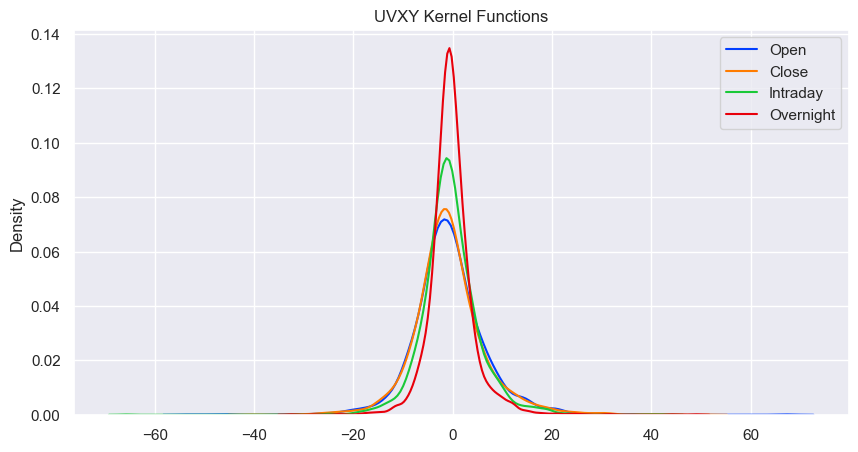

In [12]:
ax = sns.kdeplot(uvxy_open_returns, label = "Open")

sns.kdeplot(uvxy_close_returns, label = "Close")
sns.kdeplot(uvxy_intraday, label = "Intraday")
sns.kdeplot(uvxy_overnight, label = "Overnight")

plt.title("UVXY Kernel Functions")
plt.legend()
plt.show()

## <center> VIX Density </center> 

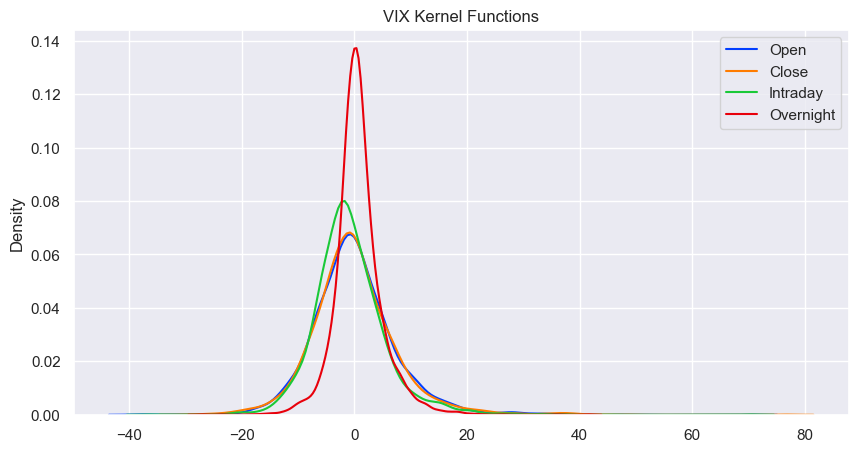

In [13]:
ax = sns.kdeplot(ivol_open_returns, label = "Open")

sns.kdeplot(ivol_close_returns, label = "Close")
sns.kdeplot(ivol_intraday, label = "Intraday")
sns.kdeplot(ivol_overnight, label = "Overnight")

plt.title("VIX Kernel Functions")
plt.legend()
plt.show()

## <center> Squared Error </center> 

## <center> $ L(\theta) = \frac{1}{N} \sum_{i=1}^{N} ((x_{i} \beta) - \hat{x})^{2} $ </center> 

## <center> $ \nabla(\beta) = \frac{2}{N} \sum_{i=1}^{N} ((x_{i} \beta) - \hat{x}) \cdot x_{i} $ </center> 

## <center> $ H(\beta) = \frac{2}{N} \sum_{i=1}^{N} x_{i}^{2} $ </center>

In [14]:
@jit(nopython = True, parallel = True)
def squared_error_regression(X, y):
    """
    
    """
    
    err_tol = 1e-7
    L = len(X)
    
    beta = 0.5
    gamma = 1
    gradient = 1
    itr_count = 0
    max_itr = 100
    
    while np.abs(gradient) > err_tol and itr_count < max_itr:
        
        for i in prange(L):
            gradient += ((X[i] * beta) - y[i]) * X[i]
            gamma += X[i]**2

        gradient *= 2 / L
        gamma *= 2 / L
        beta = beta - (gradient / gamma)
        itr_count += 1
    
    print("Iteration Count: ", itr_count)
    
    return beta

In [15]:
open_beta = squared_error_regression(ivol_open_returns, uvxy_open_returns)
interval = ivol_open_returns
open_prediction = interval * open_beta
open_r2 = compute_r2(open_prediction, uvxy_open_returns)
open_corr = np.sqrt(open_r2)

close_beta = squared_error_regression(ivol_close_returns, uvxy_close_returns)
interval = ivol_close_returns
close_prediction = interval * close_beta
close_r2 = compute_r2(close_prediction, uvxy_close_returns)
close_corr = np.sqrt(close_r2)

intraday_beta = squared_error_regression(ivol_intraday, uvxy_intraday)
interval = ivol_intraday
intraday_prediction = interval * intraday_beta
intraday_r2 = compute_r2(intraday_prediction, uvxy_intraday)
intraday_corr = np.sqrt(intraday_r2)

overnight_beta = squared_error_regression(ivol_overnight, uvxy_overnight)
interval = ivol_overnight
overnight_prediction = interval * overnight_beta
overnight_r2 = compute_r2(overnight_prediction, uvxy_overnight)
overnight_corr = np.sqrt(overnight_r2)

Iteration Count:  6
Iteration Count:  6
Iteration Count:  6
Iteration Count:  6


## <center> Aggregate Results to DataFrame </center> 

In [16]:
pd.DataFrame({
    "Open" : [open_beta, open_r2, open_corr],
    "Close" : [close_beta, close_r2, close_corr],
    "Intraday" : [intraday_beta, intraday_r2, intraday_corr],
    "Overnight" : [overnight_beta, overnight_r2, overnight_corr],
}, index = ["Beta", "R2", "Corr"])

,Open,Close,Intraday,Overnight
Beta,0.768953,0.843812,0.705861,0.698439
R2,0.581076,0.779929,0.620858,0.445495
Corr,0.762283,0.883136,0.787945,0.667454


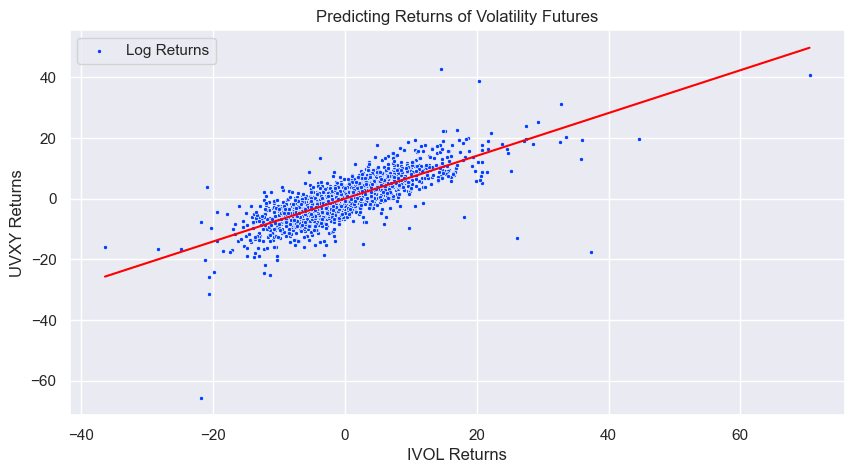

In [17]:
ax = sns.scatterplot(
    x = ivol_intraday,
    y = uvxy_intraday,
    label = "Log Returns",
    marker = "."
)

sns.lineplot(
    x = ivol_intraday,
    y = intraday_prediction,
    color = "red"
)

ax.set(
    title = "Predicting Returns of Volatility Futures",
    xlabel = "IVOL Returns",
    ylabel = "UVXY Returns",
)

plt.show()